In [105]:
import numpy as np 
import pandas as pd 
import os 
import matplotlib.pyplot as plt 
import sys
from collections import namedtuple
import math
from itertools import product

In [106]:
def length(point1, point2):
    return math.sqrt((point1.x - point2.x)**2 + (point1.y - point2.y)**2)

In [107]:
Point = namedtuple("Point", ['x', 'y'])
Facility = namedtuple("Facility", ['index', 'setup_cost', 'capacity', 'location'])
Customer = namedtuple("Customer", ['index', 'demand', 'location'])

In [108]:
data_files = os.listdir('data')

In [109]:
print(data_files)

['fl_100_12', 'fl_100_14', 'fl_50_1', 'fl_100_13', 'fl_50_6', 'fl_16_2', 'fl_25_1', 'fl_4000_1', 'fl_100_5', 'fl_1000_3', 'fl_100_2', 'fl_200_3', 'fl_200_4', 'fl_200_5', 'fl_200_2', 'fl_100_3', 'fl_100_4', 'fl_1000_2', 'fl_2000_2', 'fl_50_3', 'fl_100_11', 'fl_50_4', 'fl_2000_3', 'fl_16_1', 'fl_100_10', 'fl_50_5', 'fl_50_2', 'fl_25_3', 'fl_25_4', 'fl_3_1', 'fl_25_5', 'fl_25_2', 'fl_500_7', 'fl_500_6', 'fl_100_1', 'fl_100_6', 'fl_200_7', 'fl_100_8', 'fl_100_9', 'fl_200_1', 'fl_200_6', 'fl_100_7', 'fl_200_8']


In [110]:
def get_input_data(_id):
    file_location = 'data/'+data_files[_id]
    with open(file_location, 'r') as input_data_file:
        input_data = input_data_file.read()
    return input_data

In [111]:
def parse_input(input_data):
    # parse the input
    lines = input_data.split('\n')

    parts = lines[0].split()
    facility_count = int(parts[0])
    customer_count = int(parts[1])
    
    facilities = []
    for i in range(1, facility_count+1):
        parts = lines[i].split()
        facilities.append(Facility(i-1, float(parts[0]), int(parts[1]), Point(float(parts[2]), float(parts[3])) ))

    customers = []
    for i in range(facility_count+1, facility_count+1+customer_count):
        parts = lines[i].split()
        customers.append(Customer(i-1-facility_count, int(parts[0]), Point(float(parts[1]), float(parts[2]))))
    return parts,facility_count,customer_count,facilities,customers

In [210]:
# Input 4 is test case 2 ! 
input_data = get_input_data(4)
parts,facility_count,customer_count,facilities,customers = parse_input(input_data)

In [211]:
def plot_problem(facilities,customers):
    fig,ax = plt.subplots(figsize=(10,10))
    ax.scatter([f.location.x for f in facilities],[f.location.y for f in facilities],color='blue',marker='D')
    ax.scatter([c.location.x for c in customers],[c.location.y for c in customers],color='red',s=10)
    plt.grid()
    plt.show()

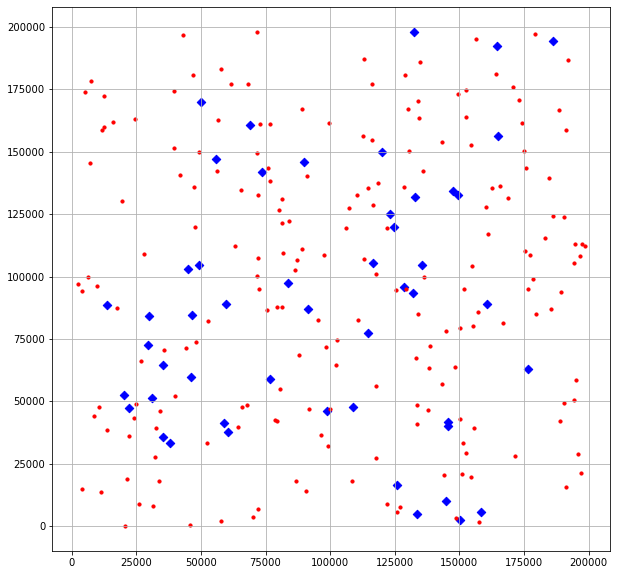

In [212]:
plot_problem(facilities,customers)

In [213]:
# this is a n_c x n_f matrix where the number at index (i,j) is the cost of assigning customer i to factory j
def compute_cost_matrix(customer_count,facility_count,facilities,customers):
    cost_matrix = np.zeros((customer_count,facility_count))
    for i in range(customer_count):
        for j in range(facility_count):
            cost_matrix[i,j] = length(customers[i].location,facilities[j].location)
    return cost_matrix

In [214]:
cost_matrix = compute_cost_matrix(customer_count,facility_count,facilities,customers)

In [215]:
import gurobipy as gp
from gurobipy import GRB

In [216]:
cartesian_prod = list(product(range(customer_count), range(facility_count)))

# Compute shipping costs

shipping_cost = {(c,f): length(customers[c].location, facilities[f].location) for c, f in cartesian_prod}

In [217]:
# setup cost is the list of setup costs
setup_cost = [f.setup_cost for f in facilities]

In [218]:
# demand is the list of demands by customers
demand = [c.demand for c in customers]

In [219]:
# capacity is the list of capacities by facility
capacity = [c.capacity for c in facilities]

In [220]:
m = gp.Model('facility_location')

#Defining decision variables
select = m.addVars(facility_count, vtype=GRB.BINARY, name='Select')
assign = m.addVars(cartesian_prod, ub=1, vtype=GRB.BINARY, name='Assign')

#Defining constraints
# First is : you cannit assign a customer to a closed facility
m.addConstrs((assign[(c,f)] <= select[f] for c,f in cartesian_prod), name='Setup2ship')
# One customer is assigned to only one facility
m.addConstrs((gp.quicksum(assign[(c,f)] for f in range(facility_count)) == 1 for c in range(customer_count)), name='Demand')
# Add constraint of capacity
m.addConstrs((gp.quicksum(assign[(c,f)]*demand[c] for c in range(customer_count)) <= capacity[f] for f in range(facility_count)),name='Capacity')

# Defining objective funcion
m.setObjective(select.prod(setup_cost)+assign.prod(shipping_cost), GRB.MINIMIZE)

m.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads



GurobiError: Model too large for size-limited license; visit https://www.gurobi.com/free-trial for a full license

In [ ]:
def get_assignment(assign):
    assignment = []
    for customer,facility in assign.keys():
        if (abs(assign[customer, facility].x) > 1e-6):
            assignment.append(facility)
    return assignment

In [221]:
facilities_open = [select[f].x for f in select.keys()]

AttributeError: Unable to retrieve attribute 'x'

In [222]:
assignment = get_assignment(assign)

AttributeError: Unable to retrieve attribute 'x'

In [223]:
def calculate_obj_from_assignment(setup_cost,facilities_open,assignment):
    sc = np.dot(facilities_open,setup_cost)
    ac = 0
    for customer in range(customer_count):
        ac += shipping_cost[(customer,assignment[customer])]
    return sc + ac 

In [224]:
calculate_obj_from_assignment(setup_cost,facilities_open,assignment)

IndexError: list index out of range

In [225]:
def plot_solution(facilities,customers,assignment):
    fig,ax = plt.subplots(figsize=(10,10))
    ax.scatter([f.location.x for f in facilities],[f.location.y for f in facilities],color='blue',marker='D')
    ax.scatter([c.location.x for c in customers],[c.location.y for c in customers],color='red',s=10)
    for customer_index in range(len(assignment)):
        customer_position = customers[customer_index].location
        facility_position = facilities[assignment[customer_index]].location
        ax.plot([customer_position.x,facility_position.x], 
                 [customer_position.y,facility_position.y], color='black', linestyle="--")
    plt.grid()
    plt.show()

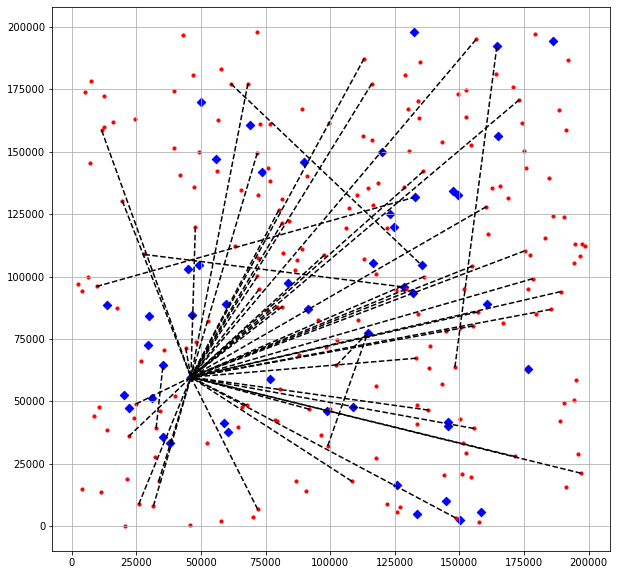

In [226]:
plot_solution(facilities,customers,assignment)

In [227]:
from pyscipopt import Model, quicksum, multidict

In [246]:
def flp(customer_count,facility_count,demand,capacity,setup_cost,shipping_cost):
    model = Model("flp")
    #y is which facilites are open 
    #x is assignment
    x,y = {},{}
    # Adding Decision Variables
    for j in range(facility_count):
        # Add variable y_j to model : is facility j open or not
        y[j] = model.addVar(vtype="B", name="y(%s)"%j)
        for i in range(customer_count):
            # Add variable x_i,j to model : is client i serviced by facility j?
            x[i,j] = model.addVar(vtype="B", name="x(%s,%s)"%(i,j))
    # Adding constraints 
    # Demand constraint : Every client is serviced.
    for i in range(customer_count):
        model.addCons(quicksum(x[i,j] for j in range(facility_count)) == 1, "Demand(%s)"%i)
    # Capacity constraint : For every factory. Sum of demand of customers is smaller than capacity.
    for j in range(facility_count):
        model.addCons(quicksum(x[i,j]*demand[i] for i in range(customer_count)) <= capacity[j]*y[j], "Capacity(%s)"%i)
    # Each client is serviced by exactly one facility
    #for (i,j) in x:
    #    model.addCons(x[i,j] == demand[i]*y[j], "Strong(%s,%s)"%(i,j))
    model.setObjective(
        quicksum(setup_cost[j]*y[j] for j in range(facility_count)) +
        quicksum(shipping_cost[i,j]*x[i,j] for i in range(customer_count) for j in range(facility_count)),
        "minimize")

    model.data = x,y
    return model

In [247]:
model = flp(customer_count, facility_count, demand, capacity, setup_cost, shipping_cost)
model.setParam('limits/time', 60)
model.optimize()
EPS = 1.e-6
x = model.data[0]
y = model.data[1]
edges = [(i,j) for (i,j) in x if model.getVal(x[i,j]) > EPS]
facilities_chosen = [j for j in y if model.getVal(y[j]) > EPS]

presolving:
   (0.0s) running MILP presolver
   (0.0s) MILP presolver found nothing
(round 1, exhaustive) 0 del vars, 0 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 250 upgd conss, 0 impls, 200 clqs
   (0.1s) probing: 51/10050 (0.5%) - 0 fixings, 0 aggregations, 0 implications, 0 bound changes
   (0.1s) probing aborted: 50/50 successive totally useless probings
   (0.1s) symmetry computation started: requiring (bin +, int -, cont +), (fixed: bin -, int +, cont -)
   (0.1s) no symmetry present
presolving (2 rounds: 2 fast, 2 medium, 2 exhaustive):
 0 deleted vars, 0 deleted constraints, 0 added constraints, 0 tightened bounds, 0 added holes, 0 changed sides, 0 changed coefficients
 0 implications, 10200 cliques
presolved problem has 10050 variables (10050 bin, 0 int, 0 impl, 0 cont) and 250 constraints
     50 constraints of type <knapsack>
    200 constraints of type <setppc>
Presolving Time: 0.07

 time | node  | left  |LP iter|LP it/n|mem/heur|mdpt |vars |cons |ro

In [248]:
def get_assignment_pyscipopt(edges,customer_count):
    assignment = ['inv']*customer_count
    for customer,facility in edges:
        if assignment[customer]=='inv':
            assignment[customer] = facility
        else:
            print('Error ! ')
    return assignment

In [249]:
assignment = get_assignment_pyscipopt(edges,customer_count)

In [250]:
facilities_open = [1 if i in facilities_chosen else 0 for i in range(facility_count) ]

In [251]:
calculate_obj_from_assignment(setup_cost,facilities_open,assignment)

3732793.4337715507

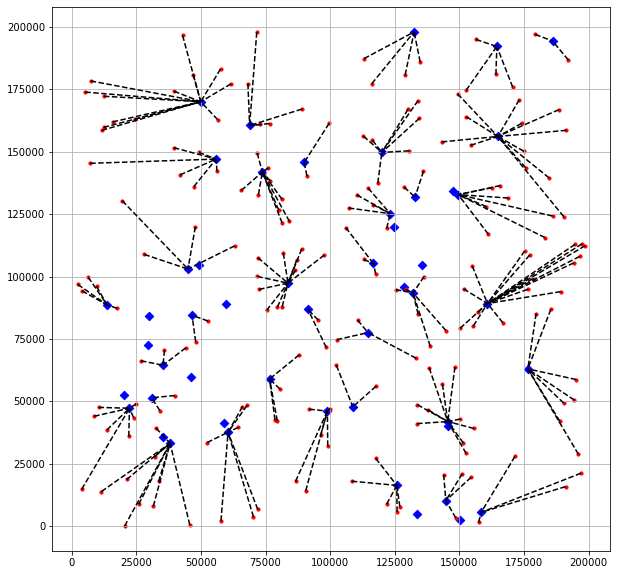

In [252]:
plot_solution(facilities,customers,assignment)

In [253]:
model.__dir__()

['__hash__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__init__',
 '__new__',
 'from_ptr',
 'to_ptr',
 'includeDefaultPlugins',
 'createProbBasic',
 'freeProb',
 'freeTransform',
 'version',
 'printVersion',
 'getProbName',
 'getTotalTime',
 'getSolvingTime',
 'getReadingTime',
 'getPresolvingTime',
 'getNLPIterations',
 'getNNodes',
 'getNTotalNodes',
 'getNFeasibleLeaves',
 'getNInfeasibleLeaves',
 'getNLeaves',
 'getNChildren',
 'getNSiblings',
 'getCurrentNode',
 'getGap',
 'getDepth',
 'infinity',
 'epsilon',
 'feastol',
 'feasFrac',
 'frac',
 'isZero',
 'isFeasZero',
 'isInfinity',
 'isFeasNegative',
 'isFeasIntegral',
 'isEQ',
 'isFeasEQ',
 'isLE',
 'isLT',
 'isGE',
 'isGT',
 'getCondition',
 'enableReoptimization',
 'lpiGetIterations',
 'setMinimize',
 'setMaximize',
 'setObjlimit',
 'getObjlimit',
 'setObjective',
 'getObjective',
 'addObjoffset',
 'getObjoffset',
 'setObjIntegral',
 'getLocalEstimate',
 'setPresolve',
 'setProbName',
 'setSeparating'

In [254]:
model.getStatus()

'optimal'

In [255]:
def check_constraints(assignment,demand,facility_count):
    filled_capacities = [0]*facility_count
    for a_index in range(len(assignment)): 
        share_of_demand = demand[a_index]
        filled_capacities[assignment[a_index]]+=share_of_demand
    return filled_capacities

In [256]:
filled_capacities = check_constraints(assignment,demand,facility_count)

In [257]:
breaks = np.where(np.array(filled_capacities)>np.array(capacity))[0]
for b in breaks:
    print('Facility {} is over capacity by {}!'.format(b,filled_capacities[b]-capacity[b]))